# VolleyMap

With this project, we aim to identify and locate the referee area within frames captured from a volleyball game using a standard lateral camera setup.

Our approach follows a hierarchical detection strategy: we first segment and identify the volleyball court boundaries, then locate the net position, and finally determine the referee's location based on these reference points. This sequential method simplifies the detection process by establishing clear spatial relationships between court elements.

Once the referee region is isolated, our pipeline can seamlessly integrate with existing computer vision models specifically trained for referee gesture recognition, enabling automated interpretation of officiating signals from the extracted referee imagery.

# Setup

### Import Libraries

In [279]:
import cv2
import numpy as np
from functools import reduce

from matplotlib import pyplot as plt  # For plotting inline images

# Set default figure size for all plots
import pylab
pylab.rcParams['figure.figsize'] = (14.0, 6.0)

### Constants

We have chosen 3 clusters to segment the image due to courts we considered in the test. It is very easy to tweak this parameter to get better results for specific courts

In [280]:
# Set the path to the input image and the number of clusters for K-means segmentation.

# Path to the volleyball game frame to be processed.
IMAGE_PATH = 'data/duca.png'

# Number of color clusters to segment the court
N_CLUSTERS = 3

## Image preparation

We begin by loading the input image and enhancing its saturation to improve color differentiation, as our methodology relies on clustering pixels based on their color characteristics. This preprocessing step is crucial for achieving better segmentation accuracy in the subsequent color-based clustering algorithm.

In [281]:
# Load the image and convert it to RGB
image = cv2.imread(IMAGE_PATH)
original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to HSV for saturation enhancement
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Enhance saturation by multiplying the S channel
h, s, v = cv2.split(hsv)
s = cv2.multiply(s, 2.0)  # Increase saturation by 100%
s = np.clip(s, 0, 255).astype(np.uint8)  # Ensure values stay within valid range

# Merge channels back and convert to RGB
enhanced_hsv = cv2.merge([h, s, v])
enhanced_rgb = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2RGB)


Display the images

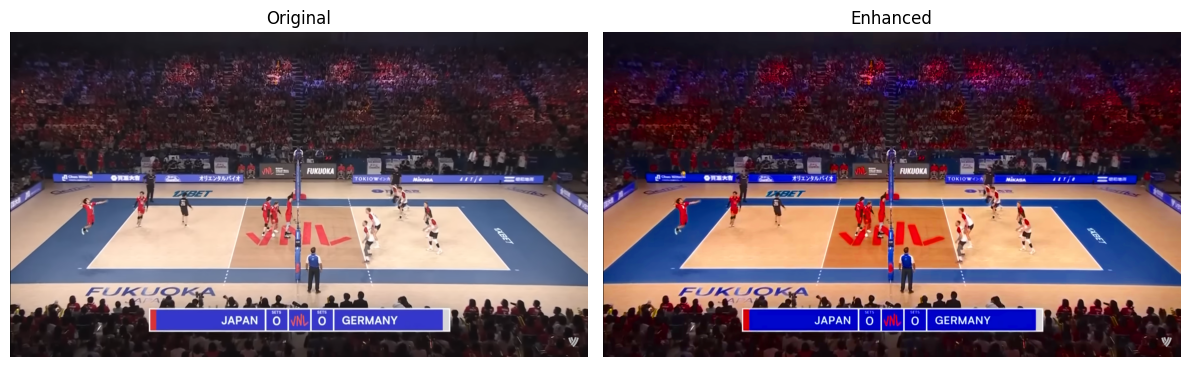

In [282]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original_rgb
axes[0].imshow(original_rgb)
axes[0].set_title('Original')
axes[0].axis('off')

# Display enhanced_rgb
axes[1].imshow(enhanced_rgb)
axes[1].set_title('Enhanced')
axes[1].axis('off')

# Show the figure
plt.tight_layout()
plt.show()

# Court recognition

As an initial step, this chapter focuses on recognizing and segmenting the volleyball court within the input image.

To accomplish this, we employ a color-based clustering approach to analyze the court's visual characteristics. Our methodology involves creating three distinct color clusters to capture the primary color regions present in the image. For each resulting cluster, we apply morphological preprocessing operations to eliminate noise, fill holes, and remove artifacts that could interfere with accurate segmentation.

Subsequently, we identify the largest connected component within each cluster, as this typically corresponds to the most significant region of that particular color. Finally, we perform a comparative analysis of these three primary components to determine which one accurately represents the actual volleyball court area, using geometric and spatial criteria to make this determination.

## K\-means

First, we apply K-means clustering segmentation to partition the image into distinct color-based clusters, enabling us to identify and separate the primary color regions within the volleyball court scene.

In [283]:
# Flatten the dimensions of the image for each channel for easier processing
# from [height, width, 3 (channels RGB)] (3 matrices) to [height * width, 3] (3 vectors)
pixels = enhanced_rgb.reshape((-1, 3)).astype(np.float32)

# Define the stop criteria for K-means:
# either at 100 max iterations or when the 1.0 (epsilon) accuracy is reached
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1.0)

# Apply K-means clustering with the specified number of clusters
# Parameters: data, k, bestLabels (none), criteria, attempts, flags (ten attempts, random centers)
_, labels, centers = cv2.kmeans(pixels, N_CLUSTERS, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Reshape the labels back to the original image dimensions
# This creates a map where each pixel is assigned to a cluster (0, 1, or 2)
labels_map = labels.reshape(enhanced_rgb.shape[:2])


In the following code block, we visualize the results of the K-means clustering algorithm.

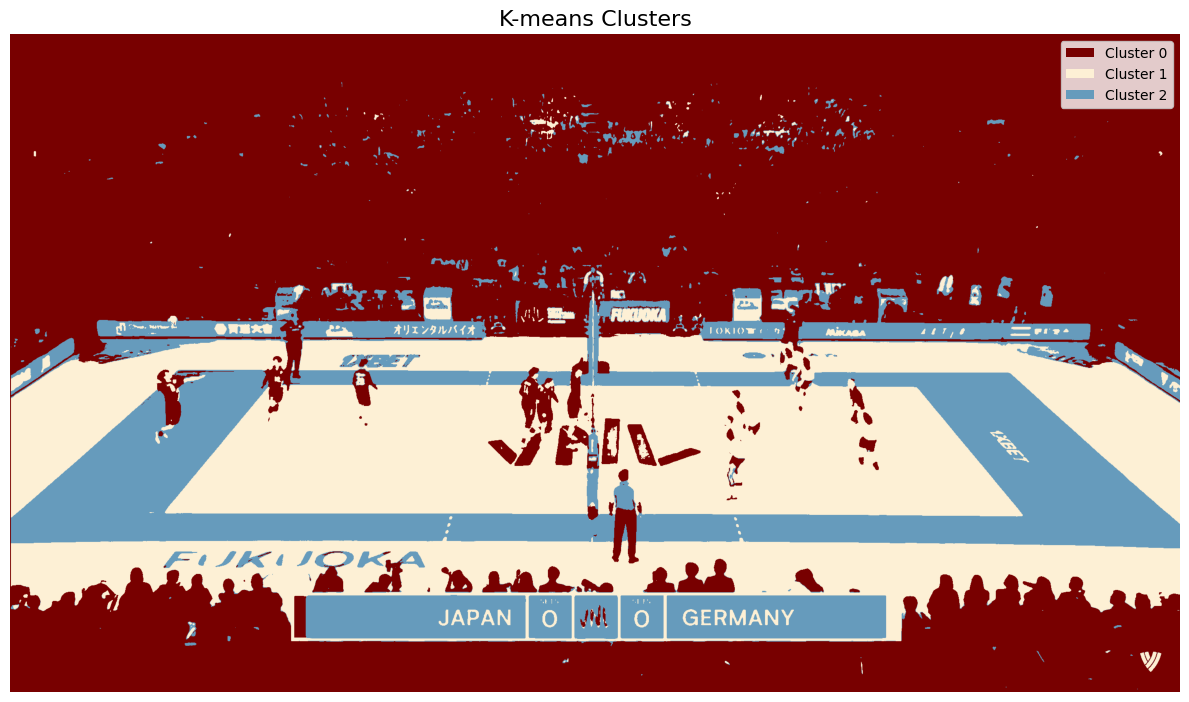

In [284]:
# Create a colored image showing all clusters
colored_clusters = np.zeros((labels_map.shape[0], labels_map.shape[1], 3), dtype=np.uint8)

# Define colors for each cluster (RGB format)
colors = [
    [120, 0, 0],        # Dark red for Cluster 0
    [253, 240, 213],    # Light beige for Cluster 1
    [102, 155, 188]     # Blue for Cluster 2
]

# Apply colors to each cluster
for i in range(N_CLUSTERS):
    mask = labels_map == i
    colored_clusters[mask] = colors[i]

# Create the plot with legend
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(colored_clusters)
ax.set_title('K-means Clusters', fontsize=16)
ax.axis('off')

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=np.array(colors[i])/255.0, label=f'Cluster {i}') 
                   for i in range(N_CLUSTERS)]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## Connected Components

The following functions will be used in subsequent code blocks.

In [ ]:
def apply_hough(image):
    """
    Apply Hough line detection and morphological operations to detect and enhance lines.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input binary image (grayscale, single channel) for line detection
        
    Returns:
    --------
    numpy.ndarray
        Binary image with detected lines enhanced using morphological closing
        
    Description:
    ------------
    This function performs the following steps:
    1. Detects lines using Probabilistic Hough Line Transform with optimized parameters
    2. Draws detected lines on a blank canvas with white color and 2-pixel thickness
    3. Converts the colored line image back to grayscale binary format
    4. Applies horizontal morphological closing to connect nearby line segments and fill gaps
    
    The function is particularly effective for detecting horizontal structures and 
    connecting fragmented line segments through morphological operations.
    """
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=10, minLineLength=5, maxLineGap=200)
    h, w = image.shape
    lines_img = np.zeros((h, w, 3), dtype=np.uint8)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lines_img, (x1, y1), (x2, y2), (255, 255, 255), 2)

    gray = cv2.cvtColor(lines_img, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Use horizontal rectangular kernel for connecting horizontal line segments
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closed


def fill_contours(mask, contours):
    """
    Fill contours by connecting border points and applying iterative Hough line detection.

    Parameters:
    -----------
    mask : numpy.ndarray
        Input binary mask (single channel, uint8) used as template for output dimensions
    contours : list
        List of contours detected by cv2.findContours, each contour is an array of points
        
    Returns:
    --------
    numpy.ndarray
        Binary mask with filled contours, same dimensions as input mask
        
    Description:
    ------------
    This function performs comprehensive contour filling through:
    1. Drawing contour outlines as thin white lines on a black canvas
    2. Connecting gaps along image borders (top, bottom, left, right edges) 
       by drawing lines between contour points that intersect each border
    3. Applying Hough line detection twice iteratively to enhance and connect line structures
    4. Finding and completely filling the resulting closed contours
    
    The border connection step is crucial for handling contours that extend to image edges,
    ensuring they form closed shapes that can be properly filled. The double Hough application
    strengthens weak connections and bridges small gaps in the contour structure.
    """
    contour_img = np.zeros_like(mask)
    cv2.drawContours(contour_img, contours, -1, 255, 1)

    h, w = contour_img.shape

    # Connect gaps on top and bottom borders
    for y in [0, h - 1]:
        row = contour_img[y, :]
        on_indices = np.where(row > 0)[0]
        if len(on_indices) >= 2:
            for i in range(len(on_indices) - 1):
                x1, x2 = on_indices[i], on_indices[i + 1]
                if x2 - x1 > 1:  # Only connect if there's a gap
                    cv2.line(contour_img, (x1, y), (x2, y), 255, 1)

    # Connect gaps on left and right borders
    for x in [0, w - 1]:
        col = contour_img[:, x]
        on_indices = np.where(col > 0)[0]
        if len(on_indices) >= 2:
            for i in range(len(on_indices) - 1):
                y1, y2 = on_indices[i], on_indices[i + 1]
                if y2 - y1 > 1:  # Only connect if there's a gap
                    cv2.line(contour_img, (x, y1), (x, y2), 255, 1)
    
    # Apply Hough line detection twice for robust line enhancement and gap filling
    closed = apply_hough(apply_hough(contour_img))

    # Find final contours and fill them completely
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(mask)
    cv2.drawContours(filled, contours, -1, 255, thickness=cv2.FILLED)
        
    return filled

### Field Identification

We have the clusters of the image. So, we have to find the connected components of the clusters and elaborate them.

In detail, for each cluster we apply an horizontal gaussian blur and a treshold, in order to smooth the image and horizontal areas.
Then, we remove the remaining horizontal artifacts from the clusters.

Given a elaburated cluster, we search for the connected components, take the biggest one for each cluster and fill its holes, using its contour. 

In [ ]:
# Initialize lists to store processing results for each cluster
filled_components = []  # Final filled components for comparison
components = []         # Largest connected components (binary masks)
masks = []             # Original cluster masks
binaries = []          # Thresholded binary masks
closeds = []           # Morphologically processed masks

# Process each cluster to find the largest connected component
# This involves preprocessing to remove noise and artifacts, then filling holes
for i in range(N_CLUSTERS):
  
  # Create binary mask for the current cluster (convert boolean to 0-255 range)
  mask = ((labels_map == i).astype(np.uint8)) * 255
  masks.append(mask)
  
  # Apply horizontal Gaussian blur to remove small artifacts
  # Large horizontal kernel (151x1) smooths out noise like players, net details, etc.
  # while preserving major horizontal structures like court boundaries
  blurred = cv2.GaussianBlur(mask, (151, 1), 0)
  
  # Apply binary threshold to create clean binary image
  # Pixels < 127 become 0 (black), >= 127 become 255 (white)
  _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
  binaries.append(binary)
  
  # Remove horizontal artifacts using morphological operations
  # Horizontal rectangular kernel (50x1) targets small horizontal noise
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
  
  # Opening: erosion followed by dilation - removes small objects
  opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
  
  # Closing: dilation followed by erosion - fills small gaps
  closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
  closeds.append(closed)
  
  # Find connected components and extract the largest one
  # This identifies separate regions and selects the most significant area
  num_labels, labels_im = cv2.connectedComponents(closed)
  component_mask = np.zeros_like(closed)
  
  if num_labels > 1:  # Ensure we have components beyond background (label 0)
    # Count pixels for each component (excluding background at index 0)
    areas = np.bincount(labels_im.flatten())[1:]
    
    # Find the component with maximum area
    max_label = np.argmax(areas) + 1  # +1 to account for background exclusion
    
    # Create mask containing only the largest component
    component_mask = (labels_im == max_label).astype(np.uint8) * 255
  
  # Store the largest component for later comparison
  components.append(component_mask)
  
  # Find contours of the largest component to prepare for hole filling
  # RETR_EXTERNAL gets only outer contours, ignoring holes
  contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  # Fill any holes within the component using custom fill_contours function
  # This ensures we have solid regions without internal gaps
  filled = fill_contours(component_mask, contours)
  filled_components.append(filled)

Visualization of processing steps for each cluster


Cluster 0 processing steps:


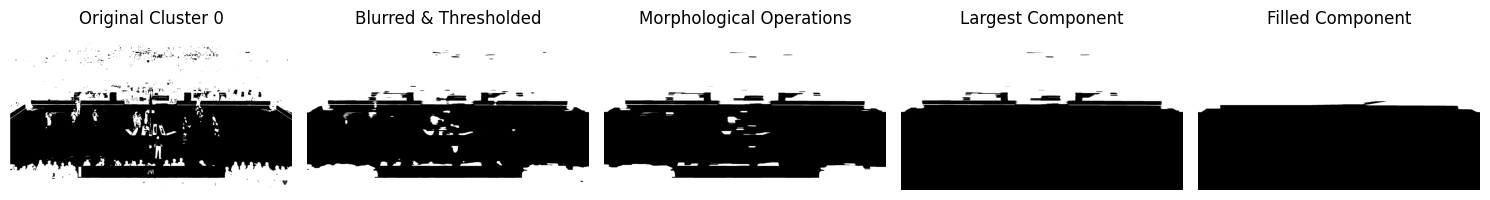


Cluster 1 processing steps:


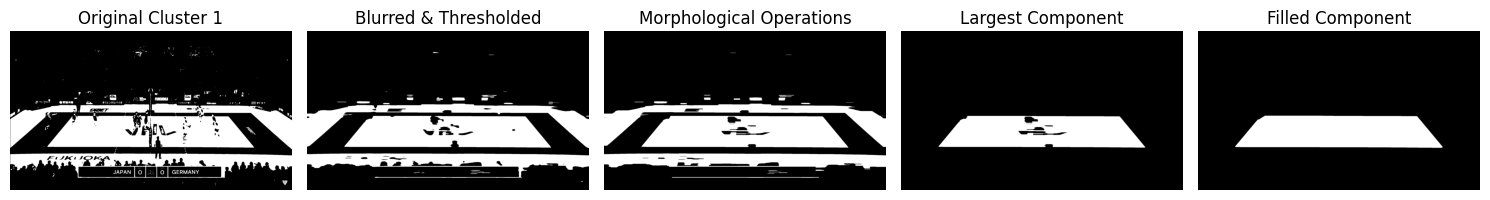


Cluster 2 processing steps:


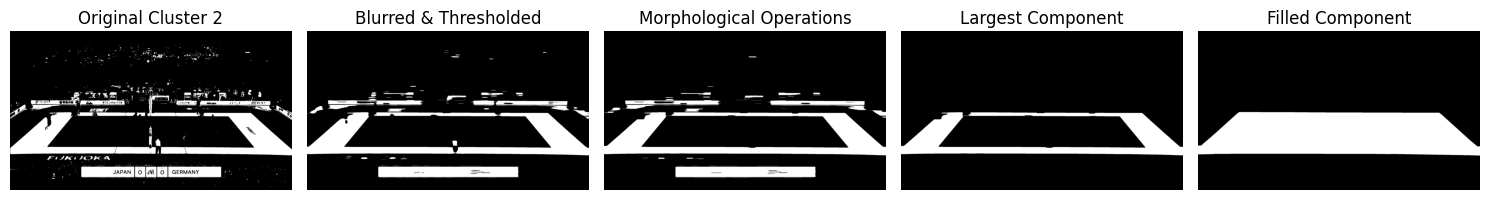

In [295]:
plt.ioff()

for i in range(N_CLUSTERS):
  print(f"\nCluster {i} processing steps:")

  plt.figure(figsize=(15, 4))
  plt.subplot(1, 5, 1)
  plt.imshow(masks[i], cmap='gray')
  plt.title(f'Original Cluster {i}')
  plt.axis('off')

  plt.subplot(1, 5, 2)
  plt.imshow(binaries[i], cmap='gray')
  plt.title(f'Blurred & Thresholded')
  plt.axis('off')

  plt.subplot(1, 5, 3)
  plt.imshow(closeds[i], cmap='gray')
  plt.title(f'Morphological Operations')
  plt.axis('off')

  plt.subplot(1, 5, 4)
  plt.imshow(components[i], cmap='gray')
  plt.title(f'Largest Component')
  plt.axis('off')
  
  plt.subplot(1, 5, 5)
  plt.imshow(filled_components[i], cmap='gray')
  plt.title(f'Filled Component')
  plt.axis('off')
  
  plt.tight_layout()
  plt.show()

plt.ion()

Now that we have the biggest connected, and filled, component for each cluster - we compare them to find which one identifies the field.

In order to do that, we have to filter out clusters having holes (from other clusters) _eg. the court around the actual field, has the "field" hole in it_.
The hole recognition is done as follows:
from a cluster's filled component, we remove all the areas in the other clusters - so that a hole that might have been filled in the previous steps, can get recognized.

Then, a similarity metric, defined by us, is introduced, thanks to that we can filter out the holed clusters.

At the end, the component with the center of mass closest to the center of the image, redefined as the one at 2/3rds of the height (lower in the image), is chosen as the field.

In [288]:
# D: [0, 255] => [False, True]
components = list( map(lambda x: x > 0, components) )

# These variables will be used to compare the clusters
min_distance = float('inf')
final_mask = None

to_removes = []

# We need the center of the image in order to understand which cluster contains the field. 
# Since the field is always is usually located a little lower due to the camera's point of view, 
# we consider the “checking” center to be slightly lower than its actual position.
W = original_rgb.shape[1]
H = original_rgb.shape[0]
CENTER = (W // 2, 2 * H // 3)

# Choose the connected component that 
# a) has no holes in the middle
# b) is closest to the center of the image
for i in range(N_CLUSTERS):
  filled = filled_components[i]
  
  # We need to remove from the component under analysis
  # the areas of the other clusters, to then ensure there are no holes
  
  # We will apply the following truth table with the other masks
  # A and not B
  #   where A is the filled connected component under analysis
  #   and B is a generic area of another cluster
  # in our case, the possible B values are united (OR of the masks) 
  # and removed all together from A
  
  other_masks = components.copy()
  del other_masks[i]
  # In this mask we add everything that is present in the other clusters
  to_removes.append(reduce(lambda x, y: x | y, other_masks))

  # Apply the truth table A and not B and then convert back to the domain [0, 255]
  mask = ( filled & (~to_removes[i]) ) * 255

  # 100% - whites_removed / total_whites (differences)      
  similarity =  1 - np.sum(filled > mask) / np.sum(filled > 0)
   
  # If a connected component doesn't have holes in it, given by other clusters
  # we choose the components which has the closest center of mass to the center
  # of the image with the height at 2/3rds 
  if similarity > 0.9:
    # Center of mass calculation
    M = cv2.moments(filled)
    if M["m00"] != 0:
      cx = int(M["m10"] / M["m00"])
      cy = int(M["m01"] / M["m00"])
      # Euclidean distance from the ideal center
      distance = np.linalg.norm(np.array([cx, cy]) - np.array([CENTER[0], CENTER[1]]))
      if distance < min_distance:
        min_distance = distance
        final_mask = filled

## Result Visualization

Visualization functions to display and analyze processing results for individual clusters.

In [ ]:
plt.ioff()

# Create main figure with 2 rows for displaying results
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(14, 6))
fig.suptitle(f'{N_CLUSTERS} Cluster Analysis', fontweight='bold', size=20, y=1.07)  

# Remove the default axes to make room for subfigures
for ax in axs:
  ax.remove()
  
# Get the gridspec from the removed axes to create subfigures
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

# Configure the first subfigure for connected components visualization
subfigs[0].suptitle('Connected components identified', fontstyle='italic')
axs = subfigs[0].subplots(1, N_CLUSTERS)

plt.ion()

for i in range(N_CLUSTERS):
  axs[i].imshow(filled_components[i])
  axs[i].axis('off')

subfigs[1].suptitle('Parts removed from the above components', fontstyle='italic')
axs = subfigs[1].subplots(1, N_CLUSTERS)

for i in range(N_CLUSTERS):
  axs[i].imshow(to_removes[i])
  axs[i].axis('off')
  axs[i].text(0.5, -0.1, f'Similarity: {int(similarity * 1000) / 10}%', transform=axs[i].transAxes, ha='center', fontsize=12)

# green overlay
overlay = np.zeros_like(original_rgb, dtype=np.uint8)
overlay[:] = (0, 255, 0)  # Pure green

# Alpha blend
alpha = 0.4  # 0 = transparent, 1 = solid green
blended = cv2.addWeighted(original_rgb, 1 - alpha, overlay, alpha, 0)

output = np.where(final_mask[:, :, np.newaxis] == 255, blended, original_rgb)

res_fig, res_ax = plt.subplots(1, 1)
res_ax.imshow(output)
res_ax.set_title('Field')

figures = []
figures.append(fig)

figures.insert(0, res_fig)

for figure in figures:
  display(figure)
  plt.close(figure)

# Net Recognition

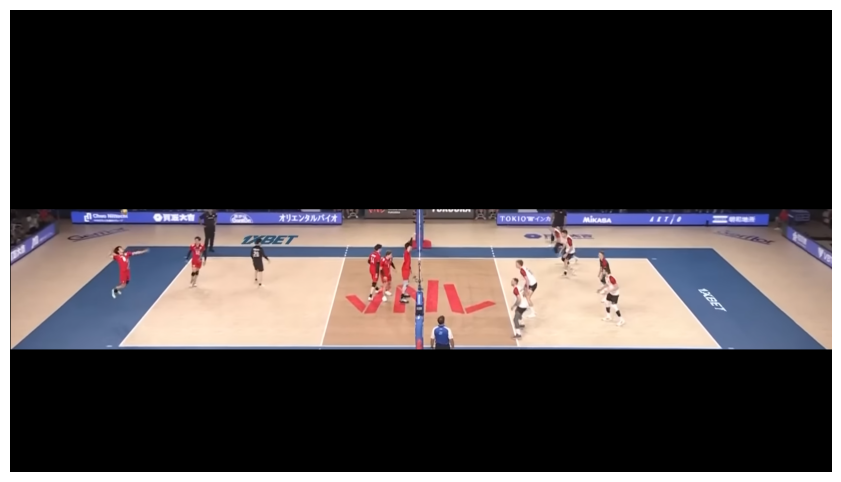

In [291]:
# Create a new empty mask
extended_mask = np.zeros_like(final_mask)
# Find the vertical bounds (y_min, y_max) of the region in final_mask
ys, xs = np.where(final_mask > 0)
if len(ys) > 0:
    y_min = ys.min()
    y_max = ys.max()
    h_region = y_max - y_min + 1
    # Calculate the new extended y_min upward by half the height
    new_y_min = max(0, int(y_min - h_region / 2))
    # Calculate the actual height to copy to avoid broadcasting errors
    src_height = y_max - y_min + 1
    dst_height = final_mask.shape[0] - new_y_min
    copy_height = min(src_height, dst_height)
    # Copy the original region to the new extended position
    extended_mask[new_y_min:y_min+copy_height, :] = 255
    # Update final_mask with the extended version

# Convert the mask to a color image
extended_mask = cv2.cvtColor(extended_mask, cv2.COLOR_GRAY2BGR)
# Apply the mask to the original image
masked_image = cv2.bitwise_and(original_rgb, extended_mask)
# Show the final image
plt.imshow(masked_image)
plt.axis('off')
plt.show()

[[1270  964]
 [1276  622]] 342.0526275297414


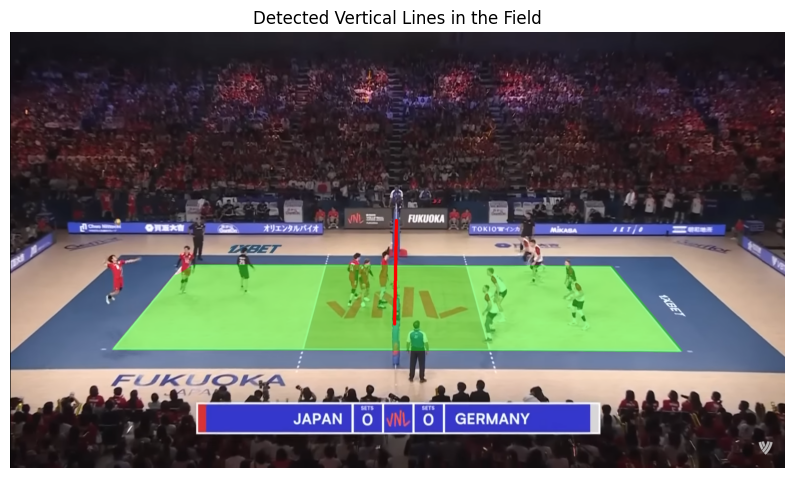

In [292]:
# Step 1: Preprocess the image
gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)  # Convert the masked image to grayscale
edges = cv2.Canny(gray, 50, 150)  # Apply edge detection using the Canny algorithm

# Step 2: Detect vertical lines using Hough Line Transform
all_lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=120, maxLineGap=1000)

# Create an empty image to draw the vertical lines
vertical_lines_img = np.zeros_like(edges)

# Step 3: Overlay the detected areas on the original masked image
overlay = output.copy()  # Create a copy of the original masked image for visualization

lines = []
W = original_rgb.shape[1]
# Filter and draw near-vertical lines
if all_lines is not None:
    for line in all_lines:
        x1, y1, x2, y2 = line[0]
        angle = abs(np.degrees(np.arctan2(y2 - y1, x2 - x1)))
        if 80 < angle < 100 and (x1 + x2) > 100 and (2 * W - (x1 + x2)) > 100:  # Filter near-vertical lines
            p1 = np.array([x1, y1])
            p2 = np.array([x2, y2])
            l = np.array([p1, p2])
            lines.append(l)

# Step 4: Compute lengths of the detected lines
def line_length(line):
    diffs = np.diff(line, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    return np.sum(segment_lengths)

lengths = [line_length(line) for line in lines]

# Step 5: Get the longest line
longest_index = np.argmax(lengths)
longest_line = lines[longest_index]
longest_length = lengths[longest_index]
print(longest_line, lengths[longest_index])
cv2.line(overlay, longest_line[0], longest_line[1], (255, 0, 0), 10)  # Draw the longest line on the overlay

# Step 6: Visualize the detected vertical lines
plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.title('Detected Vertical Lines in the Field')
plt.axis('off')
plt.show()


# Referee Area Recognition

Top pixel coordinates: [1276  622]


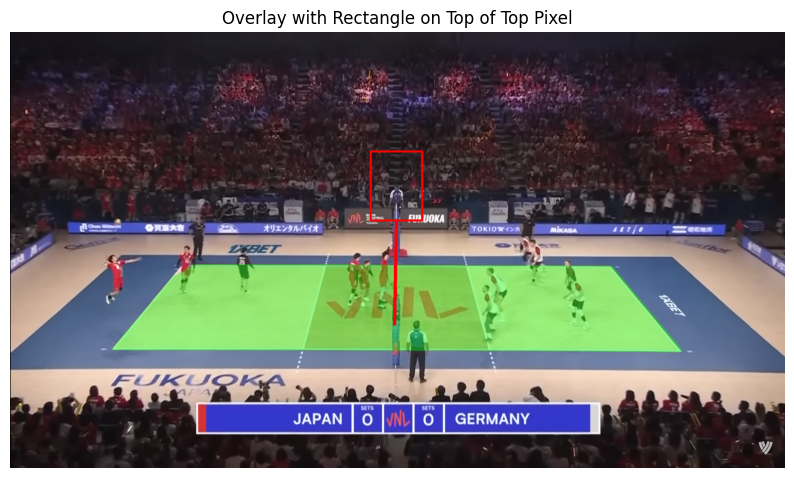

In [293]:
# Get the top pixel of the longest line
top_pixel = longest_line[0] if longest_line[0][1] < longest_line[1][1] else longest_line[1]
print(f"Top pixel coordinates: {top_pixel}")

# Define the size of the rectangle
rect_width = int(longest_length/2)  # Width of the rectangle
rect_height = int(longest_length/1.5)  # Height of the rectangle

# Calculate the top-left and bottom-right corners of the rectangle
final = overlay.copy()
top_left = (top_pixel[0] - rect_width // 2, top_pixel[1] - rect_height)
bottom_right = (top_pixel[0] + rect_width // 2, top_pixel[1])

# Draw the rectangle on the overlay
cv2.rectangle(final, top_left, bottom_right, (255, 0, 0), 5)  # Green rectangle with thickness 5

# Visualize the updated overlay
plt.figure(figsize=(10, 6))
plt.imshow(final)
plt.title('Overlay with Rectangle on Top of Top Pixel')
plt.axis('off')
plt.show()